In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
import librosa.feature as ft
import wave
import struct
import librosa
import time
import librosa.display
from os import listdir
from os.path import isfile, join
import scipy.io
from mpl_toolkits import mplot3d
import pickle
%matplotlib widget

In [2]:
def remove_init_noise(sig, fs, method="mean", ratio_parameter = 6, len_noise = 1000) :
    """
    Renvoie le signal tronqué avec le vecteurs temps associé

    # Inputs
    - sig : signal audio à tronquer
    - fs : fréquence d'échantillonnage (utile pour regénérer le vecteur temps)
    - ratio_parameter : paramètre à adapter pour couper plus ou moins le bruit. 6 par défaut

    # Ouputs
    - time : nouveau vecteur temps
    - sig : nouveau signal audio tronqué
    """
    sig /= np.max(np.abs(sig))
    noise = sig[:len_noise]
    if method == "mean" :
        noise_threshold = np.mean(np.abs(noise))
    elif method == "max" :
        noise_threshold = np.max(np.abs(noise))

    i=0
    while np.abs(sig[i]) < ratio_parameter*noise_threshold :
        i += 1
    #i correspond au premier indice au dessus du seuil
    sig = sig[i:]
    time = np.arange(len(sig))/fs
    return time, sig

In [3]:
def spectral_slope(data, sr, n_fft=2048, hop_length=None, win_length=None, 
                   window='hann', center=True, pad_mode='constant'):

    S, phase = librosa.magphase(librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                             center=center, pad_mode=pad_mode))
    slope = np.zeros((1,S.shape[1]))
    freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    for k in range(S.shape[1]):
        fit = np.polyfit(freq, S[:,k], 1)
        slope[0,k] =fit[0]
    return slope


def compute_features(data, sr, S=None, n_fft=2048, frame_length=2048, hop_length=512, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85):
    
    
    cent = librosa.feature.spectral_centroid(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, freq = freq,
                                             win_length=win_length, window=window, center=center, pad_mode=pad_mode)
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                 center=center, pad_mode=pad_mode, freq=freq, centroid=centroid, norm=norm, p=p)
    contrast = librosa.feature.spectral_contrast(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, freq=freq, fmin=fmin, n_bands=n_bands, quantile=quantile, linear=linear)
    
    flatness = librosa.feature.spectral_flatness(y=data, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, amin=amin, power=power)
    
    rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                center=center, pad_mode=pad_mode, freq=freq, roll_percent=roll_percent)
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length, center=center)
    
    rms = librosa.feature.rms(y=data, S=S, frame_length=frame_length, hop_length=hop_length, center=center, pad_mode=pad_mode)
    
    slope = spectral_slope(data, sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, 
                   window=window, center=center, pad_mode=pad_mode)
    
    dict_features = {}
    dict_features['spectral_centroid'] = cent
    dict_features['spectral_bandwidth'] = spec_bw
    dict_features['spectral_contrast'] = contrast
    dict_features['spectral_flatness'] = flatness
    dict_features['spectral_rolloff'] = rolloff
    dict_features['zero_crossing_rate'] = zcr
    dict_features['rms'] = rms
    dict_features['spectral_slope'] = slope
    
    return dict_features

In [4]:
def recup_data(monRepertoire):
    fichiers = [f for f in listdir(monRepertoire) if (isfile(join(monRepertoire, f)) and 'parametres' not in f)]
    data={}
    k=0
    with open(monRepertoire+"parametres.pickle", "rb") as handle:
            parameters_dict = pickle.load(handle)
    for fichier in fichiers:
        
        data_seul,_ = librosa.load(monRepertoire+fichier,sr=Fe)
        data[list(parameters_dict.keys())[k]] = data_seul
        k+=1
    all_cle = list(data.keys())
                
    return all_cle,data


In [5]:
def ordoner_data(data,all_cle):
    M = np.zeros((len(data[all_cle[0]]), len(data.keys())))
    i=0
    for cle in all_cle:
        M[:,i] = data[cle]
        i+=1
    return M

In [6]:
def creer_features(data,all_cle,M):
    data_features={}
    for k in range(len(all_cle)):
        data_features[all_cle[k]] = compute_features(M[:,k], sr=Fe, S=None, n_fft=2048, hop_length=256, win_length=None, window='hann',
                         center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                         p=2, amin=1e-10, power=2.0,roll_percent=0.85)
    return data_features

In [7]:
def recup_features(repertoire_features):
    with open(repertoire_features, "rb") as handle:
        dict_class = pickle.load(handle)
    return dict_class

In [8]:
features_already_calculate = True #Si les features sont dejà calculé pour ce dataset, mettre la valeur True
enregistrer_features = False #Si les features ne sont pas calculé pour ce dataset et qu'on veut enregistrer, mettre la valeur True
repertoire_features = "../../Mesures/1ier_data_set/audio_features.pickle" #repertoire pour enregistrer et load les featrues


Fe = 2**15 #Faire très attention, Fe peut changer en fonction du dataset qu'on load
repertoire_1 = '../../Mesures/1ier_data_set/acier/'
repertoire_2 = '../../Mesures/1ier_data_set/medium_1/'
repertoire_3 = '../../Mesures/1ier_data_set/medium_2/'
repertoire_4 = '../../Mesures/1ier_data_set/plexi/'

liste_repertoire = [repertoire_1,repertoire_2,repertoire_3,repertoire_4]



if features_already_calculate == False:
    dict_class={}
    
    for repertoire in liste_repertoire:
        dict_class[repertoire]={}
        all_cle,data = recup_data(repertoire)
        M=ordoner_data(data,all_cle)
        data_features = creer_features(data,all_cle,M)
        
        M_spec_bw = np.zeros((len(data_features[all_cle[0]]['spectral_bandwidth'][0]),len(all_cle)))
        M_cent = np.zeros((len(data_features[all_cle[0]]['spectral_centroid'][0]),len(all_cle)))
        M_contrast = np.zeros((len(data_features[all_cle[0]]['spectral_contrast'][0]),len(all_cle)))
        M_flatness = np.zeros((len(data_features[all_cle[0]]['spectral_flatness'][0]),len(all_cle)))
        M_slope = np.zeros((len(data_features[all_cle[0]]['spectral_slope'][0]),len(all_cle)))
        M_rolloff= np.zeros((len(data_features[all_cle[0]]['spectral_rolloff'][0]),len(all_cle)))
        i=0
        for cle in all_cle:
            M_spec_bw[:,i] = data_features[cle]['spectral_bandwidth'][0]
            M_cent[:,i] = data_features[cle]['spectral_centroid'][0]
            M_contrast[:,i] = data_features[cle]['spectral_contrast'][0]
            M_flatness[:,i] = data_features[cle]['spectral_flatness'][0]
            M_slope[:,i] = data_features[cle]['spectral_slope'][0]
            M_rolloff[:,i] = data_features[cle]['spectral_rolloff'][0]
            i+=1
        
        dict_class[repertoire]['spectral_bandwidth'] = M_spec_bw
        dict_class[repertoire]['spectral_centroid'] = M_cent
        dict_class[repertoire]['spectral_contrast'] = M_contrast
        dict_class[repertoire]['spectral_flatness'] = M_flatness
        dict_class[repertoire]['spectral_slope'] = M_slope
        dict_class[repertoire]['spectral_rolloff'] = M_slope
    
    if enregistrer_features:
        with open(repertoire_features, 'wb') as f:
            pickle.dump(dict_class, f)
    
    
else:
    dict_class = recup_features(repertoire_features)

In [9]:
l = Fe*3/256 #256 c'est pour hop_length, 3 la durée en seconde
debut = int(l//2) #Séparation entre l'attaque et le reste
fin = -10 #Il faut couper la fin car ça peut faire n'importe quoi sur les dernières frames

dict_class_mean={}

for repertoire in liste_repertoire:
    M_spec_bw = dict_class[repertoire]['spectral_bandwidth']
    M_cent = dict_class[repertoire]['spectral_centroid']
    M_contrast = dict_class[repertoire]['spectral_contrast']
    M_flatness = dict_class[repertoire]['spectral_flatness']
    M_slope = dict_class[repertoire]['spectral_slope']
    M_rolloff = dict_class[repertoire]['spectral_rolloff']


    M_spec_bw_mean = np.mean(M_spec_bw[debut:fin,:] /np.amax(np.abs(M_spec_bw[debut:fin,:]),axis=0), axis=0)
    M_cent_mean = np.mean(M_cent[debut:fin,:] /np.amax(np.abs(M_cent[debut:fin,:]),axis=0), axis=0)
    M_contrast_mean = np.mean(M_contrast[debut:fin,:] /np.amax(np.abs(M_contrast[debut:fin,:]),axis=0), axis=0)
    M_flatness_mean = np.mean(M_flatness[debut:fin,:] /np.amax(np.abs(M_flatness[debut:fin,:]),axis=0), axis=0)
    M_slope_mean = np.mean(M_slope[debut:fin,:] /np.amax(np.abs(M_slope[debut:fin,:]),axis=0), axis=0)
    M_rolloff_mean = np.mean(M_rolloff[debut:fin,:] /np.amax(np.abs(M_rolloff[debut:fin,:]),axis=0), axis=0)

    dict_class_mean[repertoire] = {}
    dict_class_mean[repertoire]['spectral_bandwidth_mean'] = M_spec_bw_mean
    dict_class_mean[repertoire]['spectral_centroid_mean'] = M_cent_mean
    dict_class_mean[repertoire]['spectral_contrast_mean'] = M_contrast_mean
    dict_class_mean[repertoire]['spectral_flatness_mean'] = M_flatness_mean
    dict_class_mean[repertoire]['spectral_slope_mean'] = M_slope_mean
    dict_class_mean[repertoire]['spectral_rolloff_mean'] = M_rolloff_mean

In [10]:
from itertools import combinations
liste_type_features = list(dict_class_mean[repertoire_1].keys())
liste_comb = list(combinations(liste_type_features, 2))
liste_comb_3D = list(combinations(liste_type_features, 3))

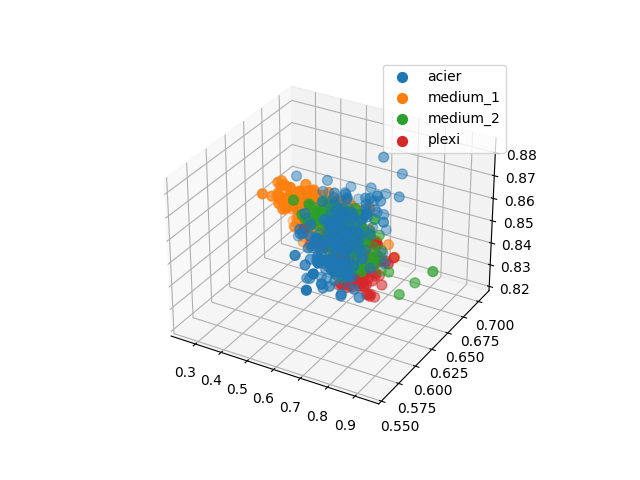

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
for cle in dict_class_mean.keys():
    x_axis = dict_class_mean[cle]['spectral_contrast_mean']
    y_axis = dict_class_mean[cle]['spectral_flatness_mean']
    z_data = dict_class_mean[cle]['spectral_bandwidth_mean']
    ax.scatter3D(x_axis,y_axis,z_data,marker ='o', s=50, label=cle[28:-1])
    ax.legend()

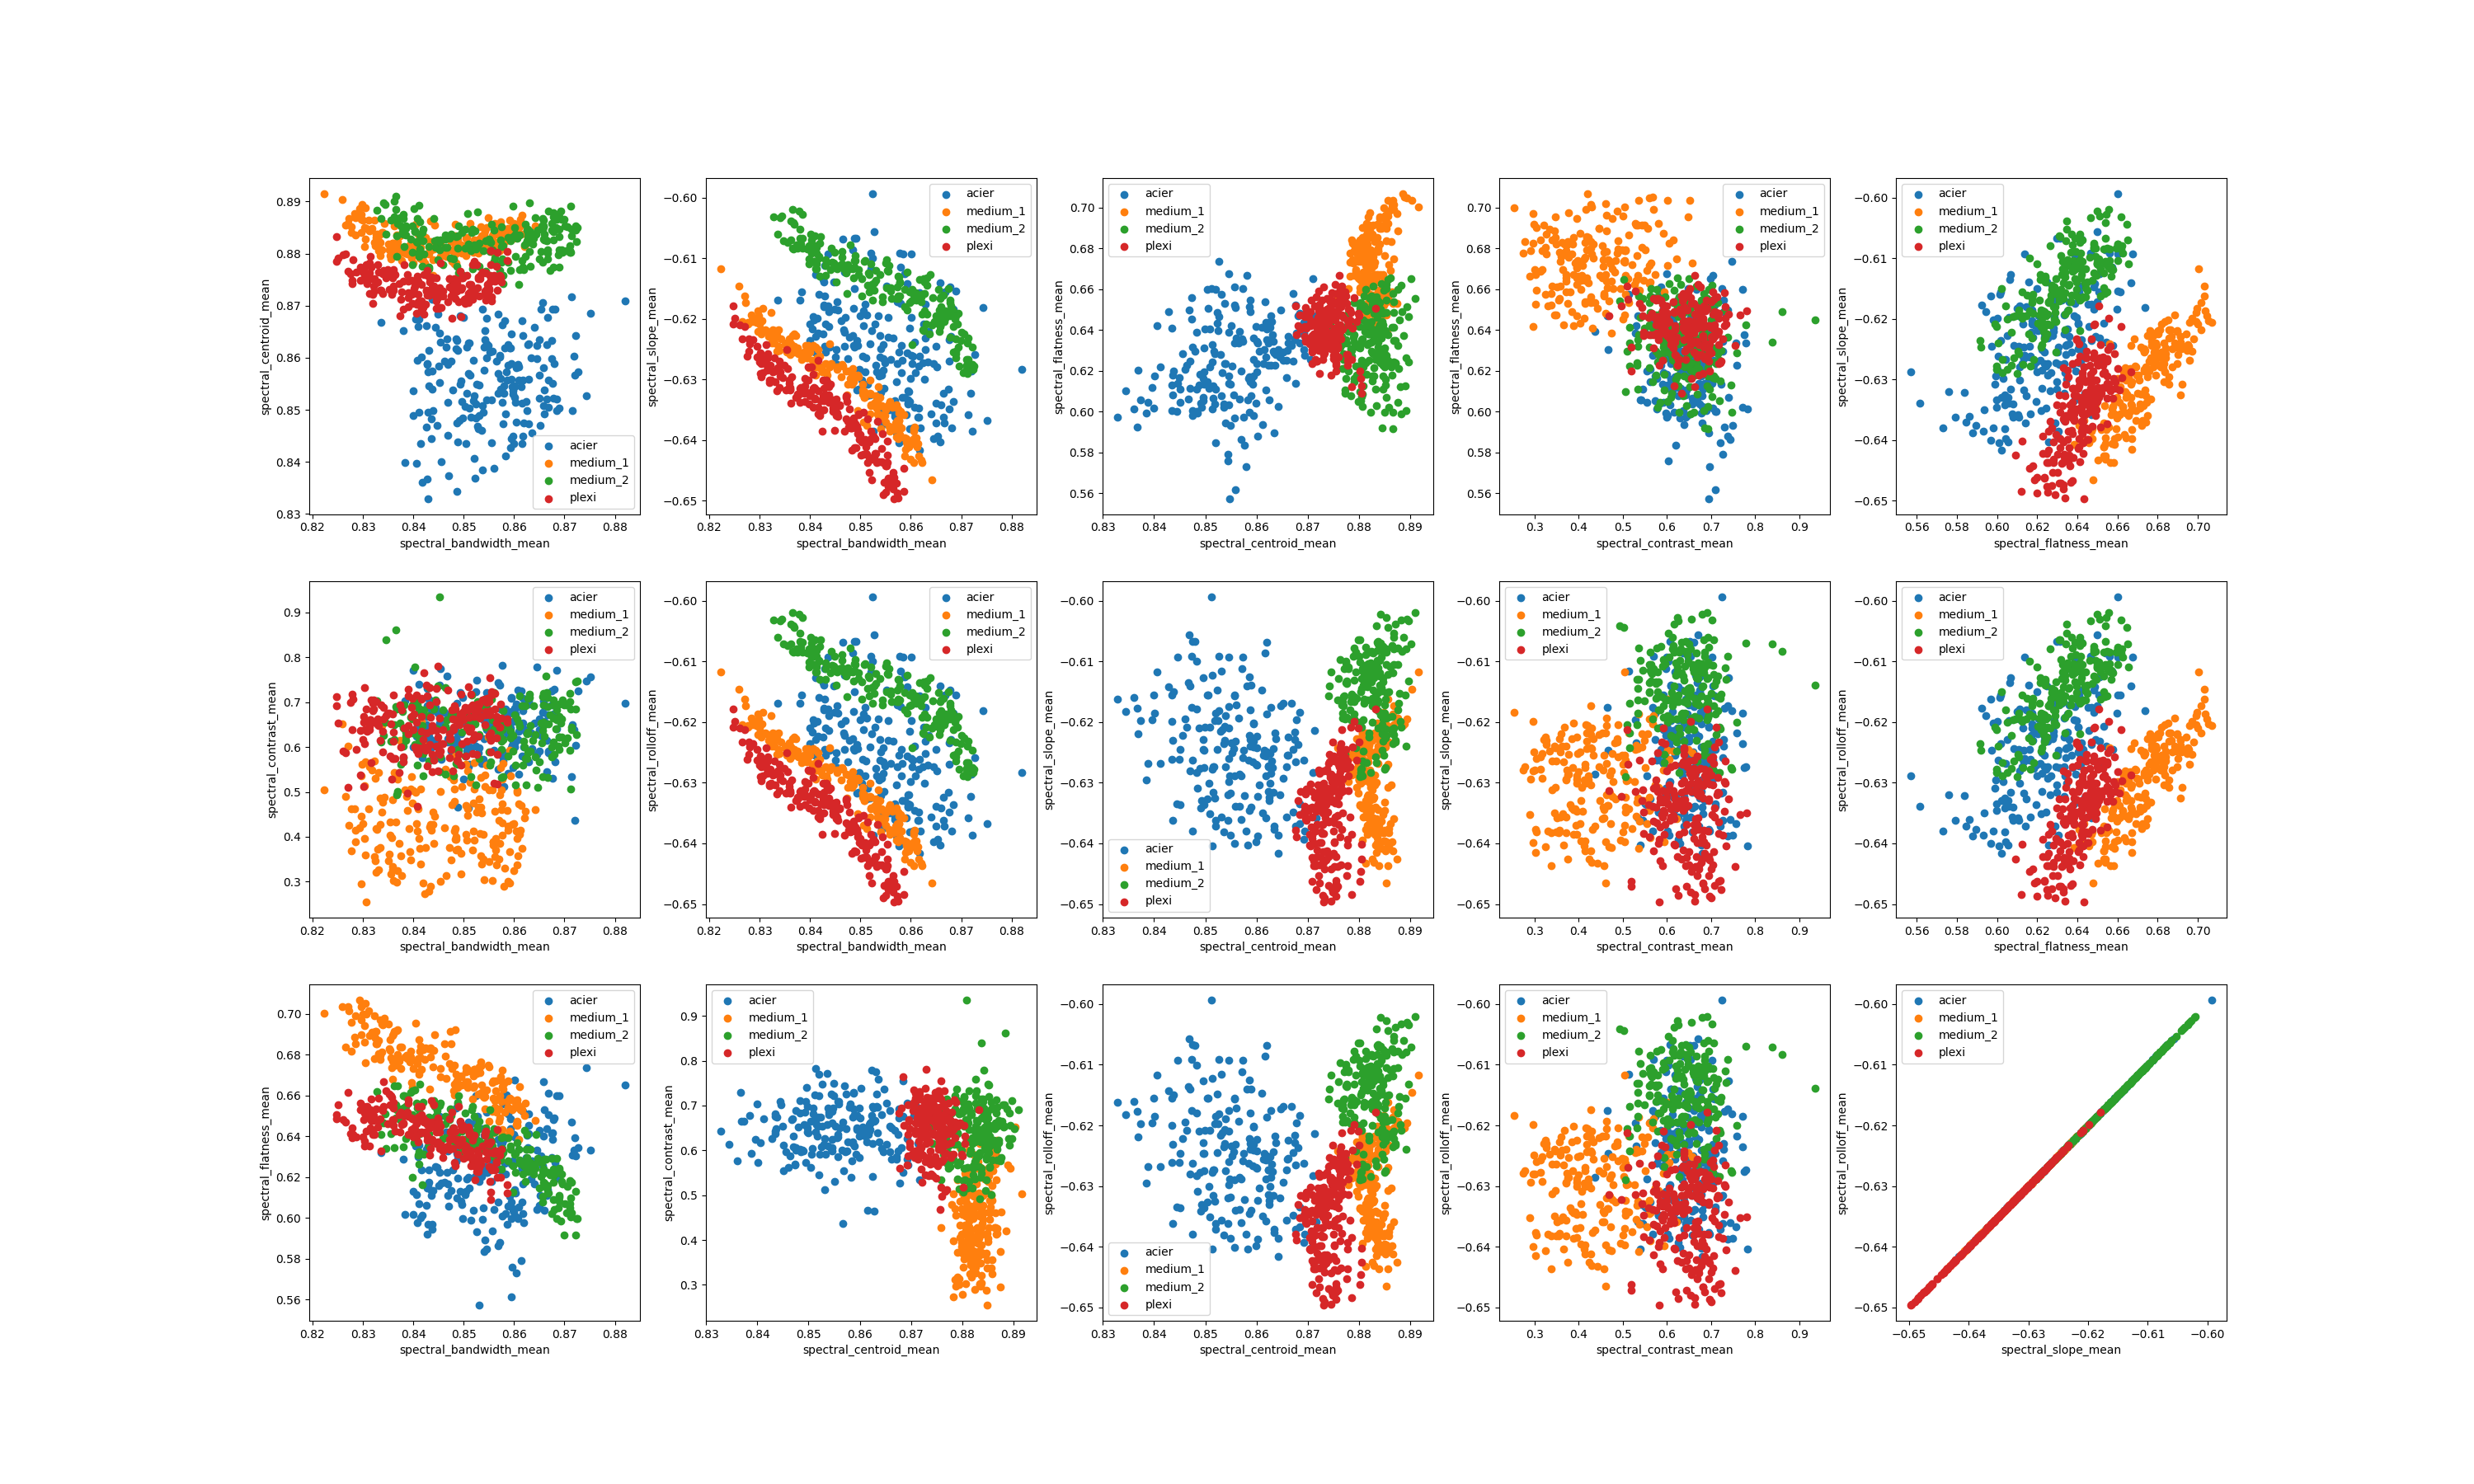

In [12]:
fig, ax = plt.subplots(3,5, figsize=(30,int(30*(3/5))))
i=0
j=0
for combinaison in liste_comb:
    for cle in dict_class_mean.keys():
        x_axis = dict_class_mean[cle][combinaison[0]]
        y_axis = dict_class_mean[cle][combinaison[1]]
        ax[i,j].scatter(x_axis,y_axis,label=cle[28:-1])
        ax[i,j].set_xlabel(combinaison[0])
        ax[i,j].set_ylabel(combinaison[1])
        ax[i,j].legend()
    i+=1
    if i%3==0:
        j+=1
        i=0

# Comparaison entre synthèse et expérience

In [13]:
repertoire_features_exp = '../../Mesures/Mesures_2023.01.27_LAM_normalise/audio_features_exp.pickle'
features_already_calculate_exp = True
enregister_features_exp = False
monRepertoire_experience = '../../Mesures/Mesures_2023.01.27_LAM_normalise/'


if features_already_calculate_exp == False:

    fichiers_table = [f for f in listdir(monRepertoire_experience) if not isfile(join(monRepertoire_experience, f))]
    data_experience = {}
    for matiere in fichiers_table:
        fichiers_corde = [f for f in listdir(monRepertoire_experience+matiere) if not isfile(join(monRepertoire_experience+matiere, f))]
        for corde in fichiers_corde:
            fichiers_mat = [f for f in listdir(monRepertoire_experience+matiere+'/'+corde) if (isfile(join(monRepertoire_experience+matiere+'/'+corde, f) ))]
            for mat in fichiers_mat:
                if mat != ".DS_Store":
                    sig = scipy.io.loadmat(monRepertoire_experience+matiere+'/'+corde+'/'+mat)['acc_t']
                    fs = scipy.io.loadmat(monRepertoire_experience+matiere+'/'+corde+'/'+mat)['fs'][0][0]
                    time, wav = remove_init_noise(sig, fs, method="mean", ratio_parameter = 6, len_noise = 10000)
                    
                    wav = wav[:int(fs*3)] #3 parce que les samples synthétiques font 3 secondes
                    data_experience[matiere+'_'+corde+'_'+mat] = {}
                    data_experience[matiere+'_'+corde+'_'+mat]['data'] = wav
                    data_experience[matiere+'_'+corde+'_'+mat]['table_matiere'] = matiere
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_matiere'] = corde
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_plectre'] = mat
                    data_experience[matiere+'_'+corde+'_'+mat]['Fe'] = fs

                    if matiere == 'Metal':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 2700
                    if matiere == 'Plexi':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 1180
                    if matiere == 'Medium_1':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 600
                    if matiere == 'Medium_2':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 800

                    if 'C_1' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 1
                    if 'C_2' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 2
                    if 'C_3' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 3
                    if 'C_4' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 4
                    if 'C_5' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 5
                    if 'C_6' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 6

                    if 'P_1' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 1
                    if 'P_2' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 2
                    if 'P_3' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 3
                    if 'P_4' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 4
                        
    all_cle_exp = list(data_experience.keys())
    x_exp = data_experience[all_cle_exp[0]]['data']
    Fe_exp = data_experience[all_cle_exp[0]]['Fe']

    M_exp = np.zeros((len(x_exp), len(data_experience.keys())))
    i=0
    for cle in all_cle_exp:
        M_exp[:,i] = np.reshape(data_experience[cle]['data'],(len(x_exp)))
        i+=1
        
    data_features_exp={}
    for k in range(len(data_experience.keys())):
        data_features_exp[all_cle_exp[k]] = compute_features(M_exp[:,k], sr=Fe_exp, S=None, n_fft=2048, hop_length=256, win_length=None, window='hann',
                         center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                         p=2, amin=1e-10, power=2.0,roll_percent=0.85)
    if enregister_features_exp:
        with open(repertoire_features_exp, 'wb') as f:
            pickle.dump(data_features_exp, f)
    

else:
    data_features_exp = recup_features(repertoire_features_exp)
    all_cle_exp = list(data_features_exp.keys())

In [14]:
dict_class_mean_exp={}
Fe_exp = 51200
l_exp = Fe_exp*3/256 #256 c'est pour hop_length, 3 la durée en seconde
debut_exp = int(l_exp//2) #Séparation entre l'attaque et le reste
fin_exp = -10


for cle in all_cle_exp:
    
    M_spec_bw_exp = data_features_exp[cle]['spectral_bandwidth'][0]
    M_cent_exp = data_features_exp[cle]['spectral_centroid'][0]
    M_contrast_exp = data_features_exp[cle]['spectral_contrast'][0]
    M_flatness_exp = data_features_exp[cle]['spectral_flatness'][0]
    M_slope_exp = data_features_exp[cle]['spectral_slope'][0]
    M_rolloff_exp = data_features_exp[cle]['spectral_rolloff'][0]

    M_spec_bw_mean_exp = np.mean(M_spec_bw_exp[debut_exp:fin_exp] /np.max(np.abs(M_spec_bw_exp[debut_exp:fin_exp])))
    M_cent_mean_exp = np.mean(M_cent_exp[debut_exp:fin_exp] /np.max(np.abs(M_cent_exp[debut_exp:fin_exp])))
    M_contrast_mean_exp = np.mean(M_contrast_exp[debut_exp:fin_exp] /np.max(np.abs(M_contrast_exp[debut_exp:fin_exp])))
    M_flatness_mean_exp = np.mean(M_flatness_exp[debut_exp:fin_exp] /np.max(np.abs(M_flatness_exp[debut_exp:fin_exp])))
    M_slope_mean_exp = np.mean(M_slope_exp[debut_exp:fin_exp] /np.max(np.abs(M_slope_exp[debut_exp:fin_exp])))
    M_rolloff_mean_exp = np.mean(M_rolloff_exp[debut_exp:fin_exp] /np.max(np.abs(M_rolloff_exp[debut_exp:fin_exp])))


    dict_class_mean_exp[cle] = {}
    dict_class_mean_exp[cle]['spectral_bandwidth_mean'] = M_spec_bw_mean_exp
    dict_class_mean_exp[cle]['spectral_centroid_mean'] = M_cent_mean_exp
    dict_class_mean_exp[cle]['spectral_contrast_mean'] = M_contrast_mean_exp
    dict_class_mean_exp[cle]['spectral_flatness_mean'] = M_flatness_mean_exp
    dict_class_mean_exp[cle]['spectral_slope_mean'] = M_slope_mean_exp
    dict_class_mean_exp[cle]['spectral_rolloff_mean'] = M_rolloff_mean_exp


# Plot des features moyennes pour les expériences

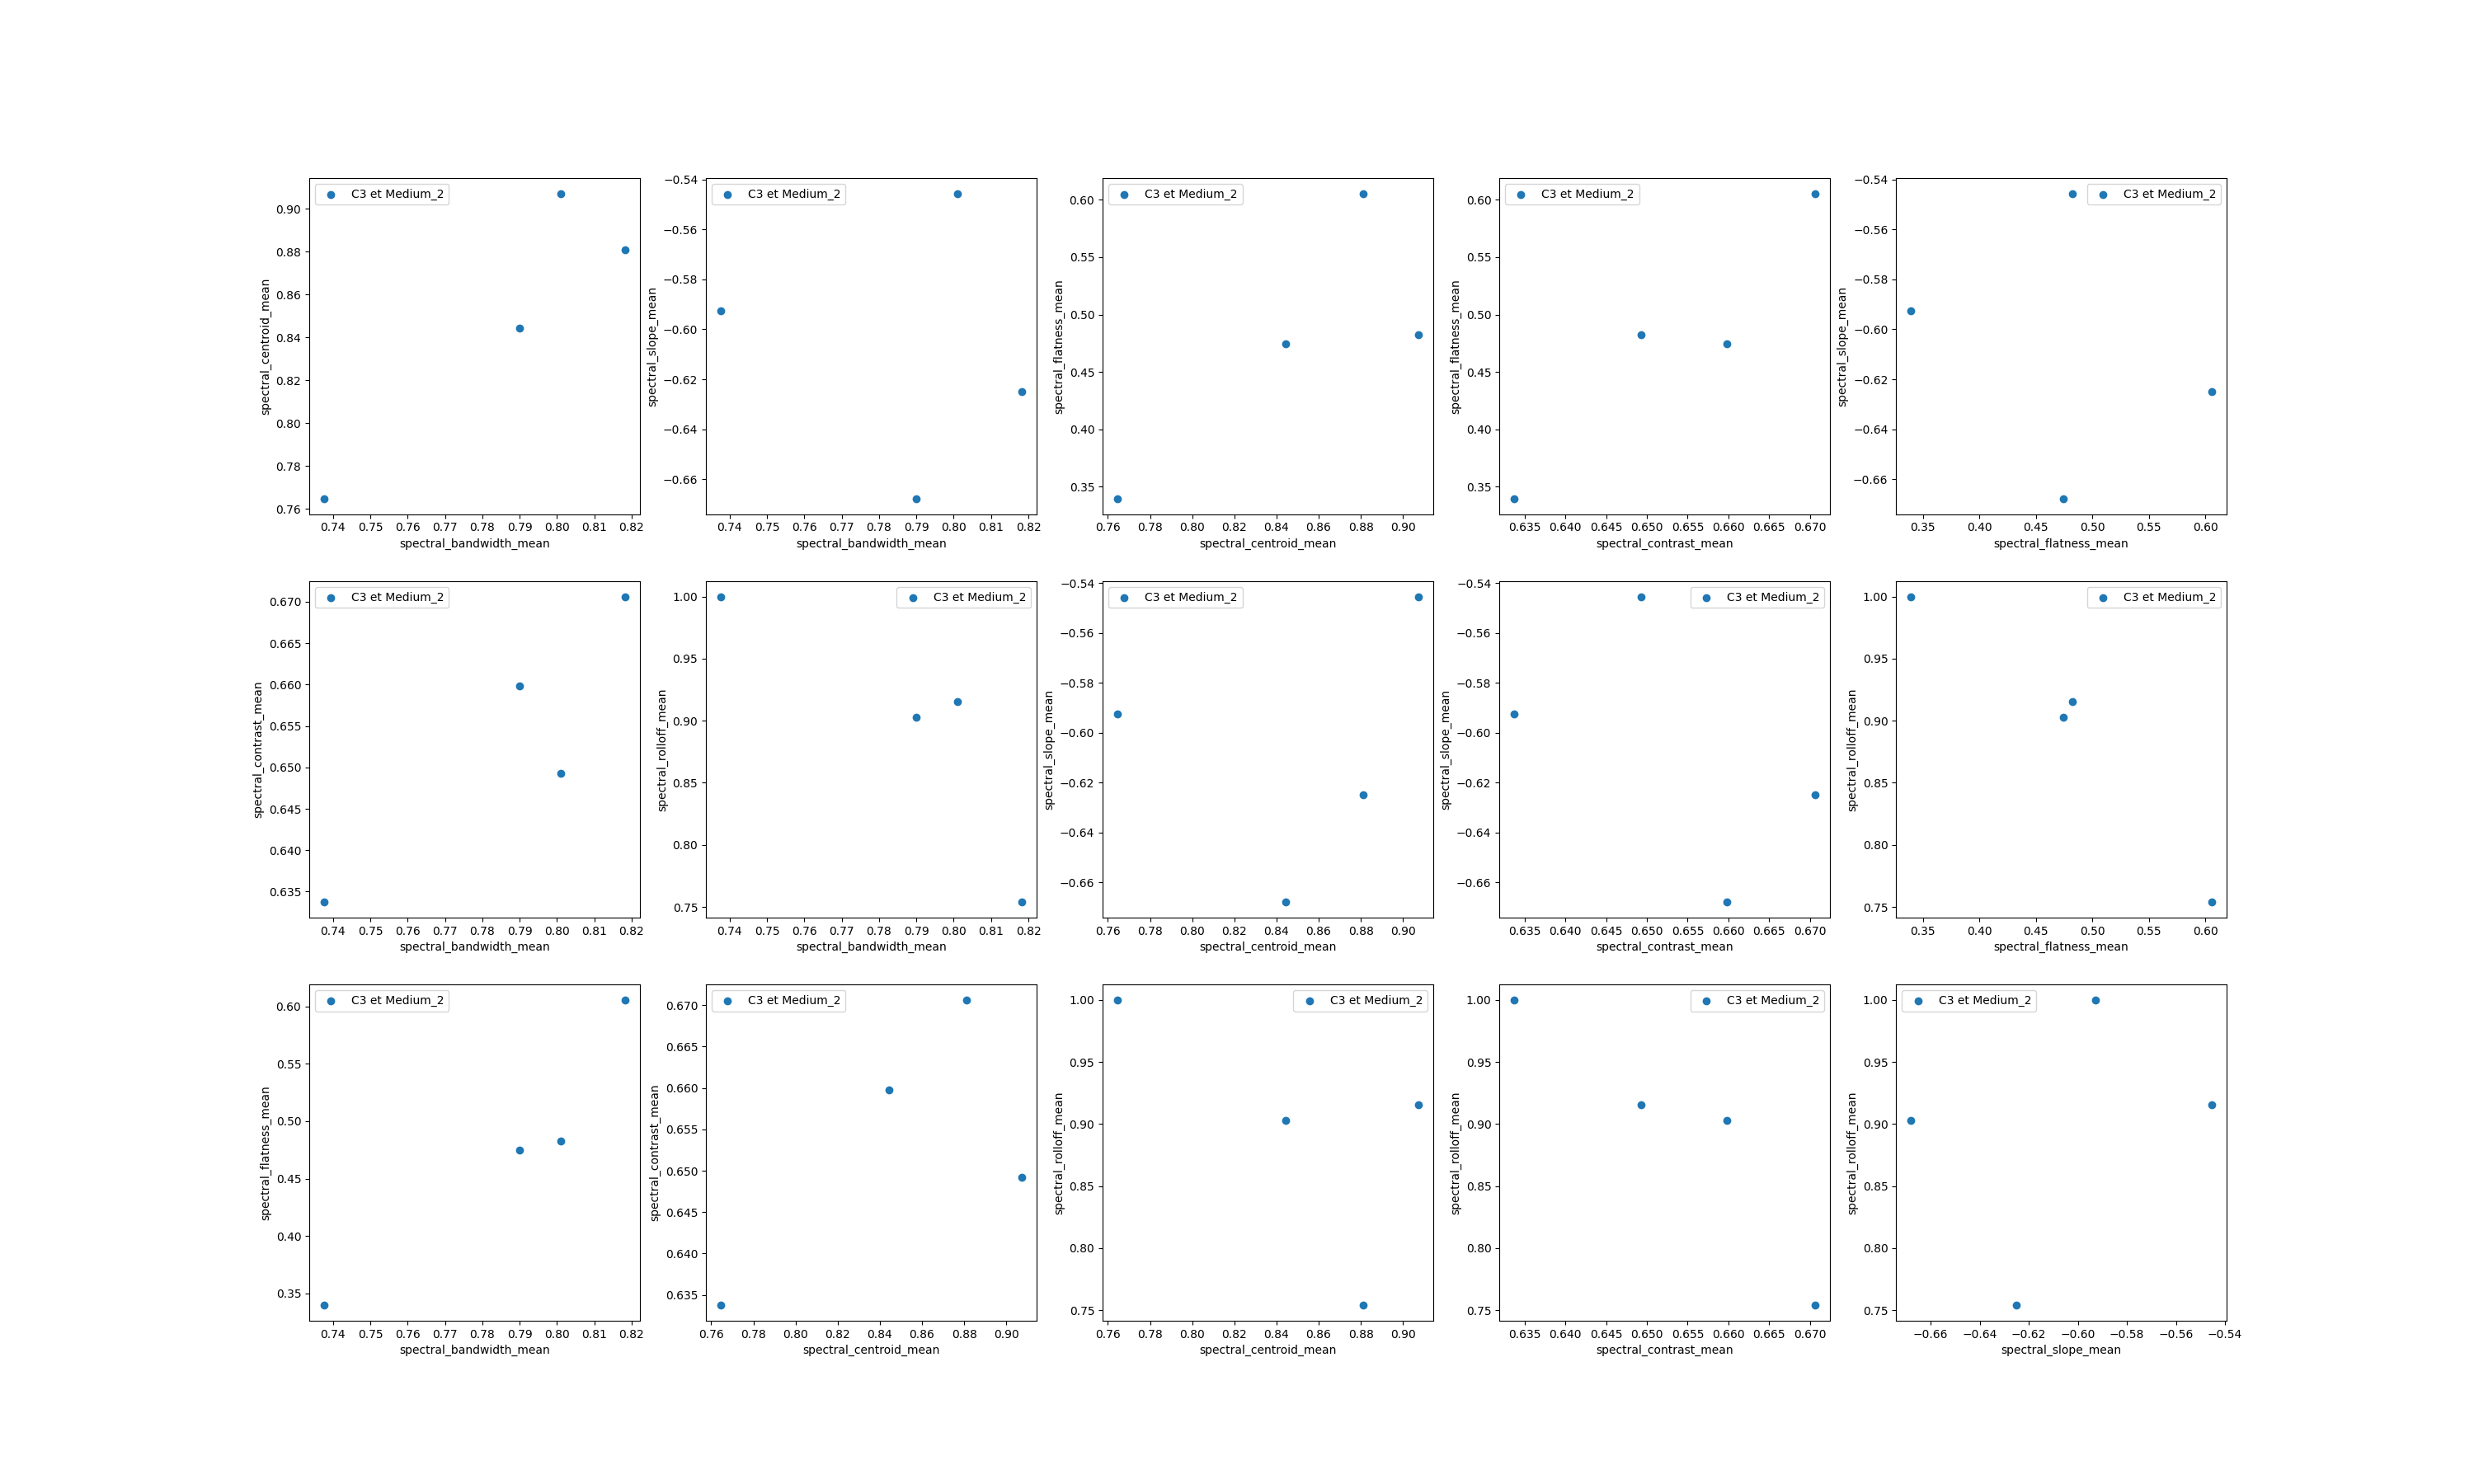

In [15]:
fig, ax = plt.subplots(3,5, figsize=(30,int(30*(3/5))))
i=0
j=0
for combinaison in liste_comb:
    x_axis = []
    y_axis = []
    for cle in all_cle_exp:
        if 'C_3' in cle and 'Medium_2' in cle: # Il faut bien choisir quelles données d'expériences on veut visualiser
            x_axis.append(dict_class_mean_exp[cle][combinaison[0]])
            y_axis.append(dict_class_mean_exp[cle][combinaison[1]])
    ax[i,j].scatter(x_axis,y_axis,label='C3 et Medium_2')
    ax[i,j].set_xlabel(combinaison[0])
    ax[i,j].set_ylabel(combinaison[1])
    ax[i,j].legend()
    i+=1
    if i%3==0:
        j+=1
        i=0
    

# Comparaison entre les features moyennes de la synthèse et de l'expérience

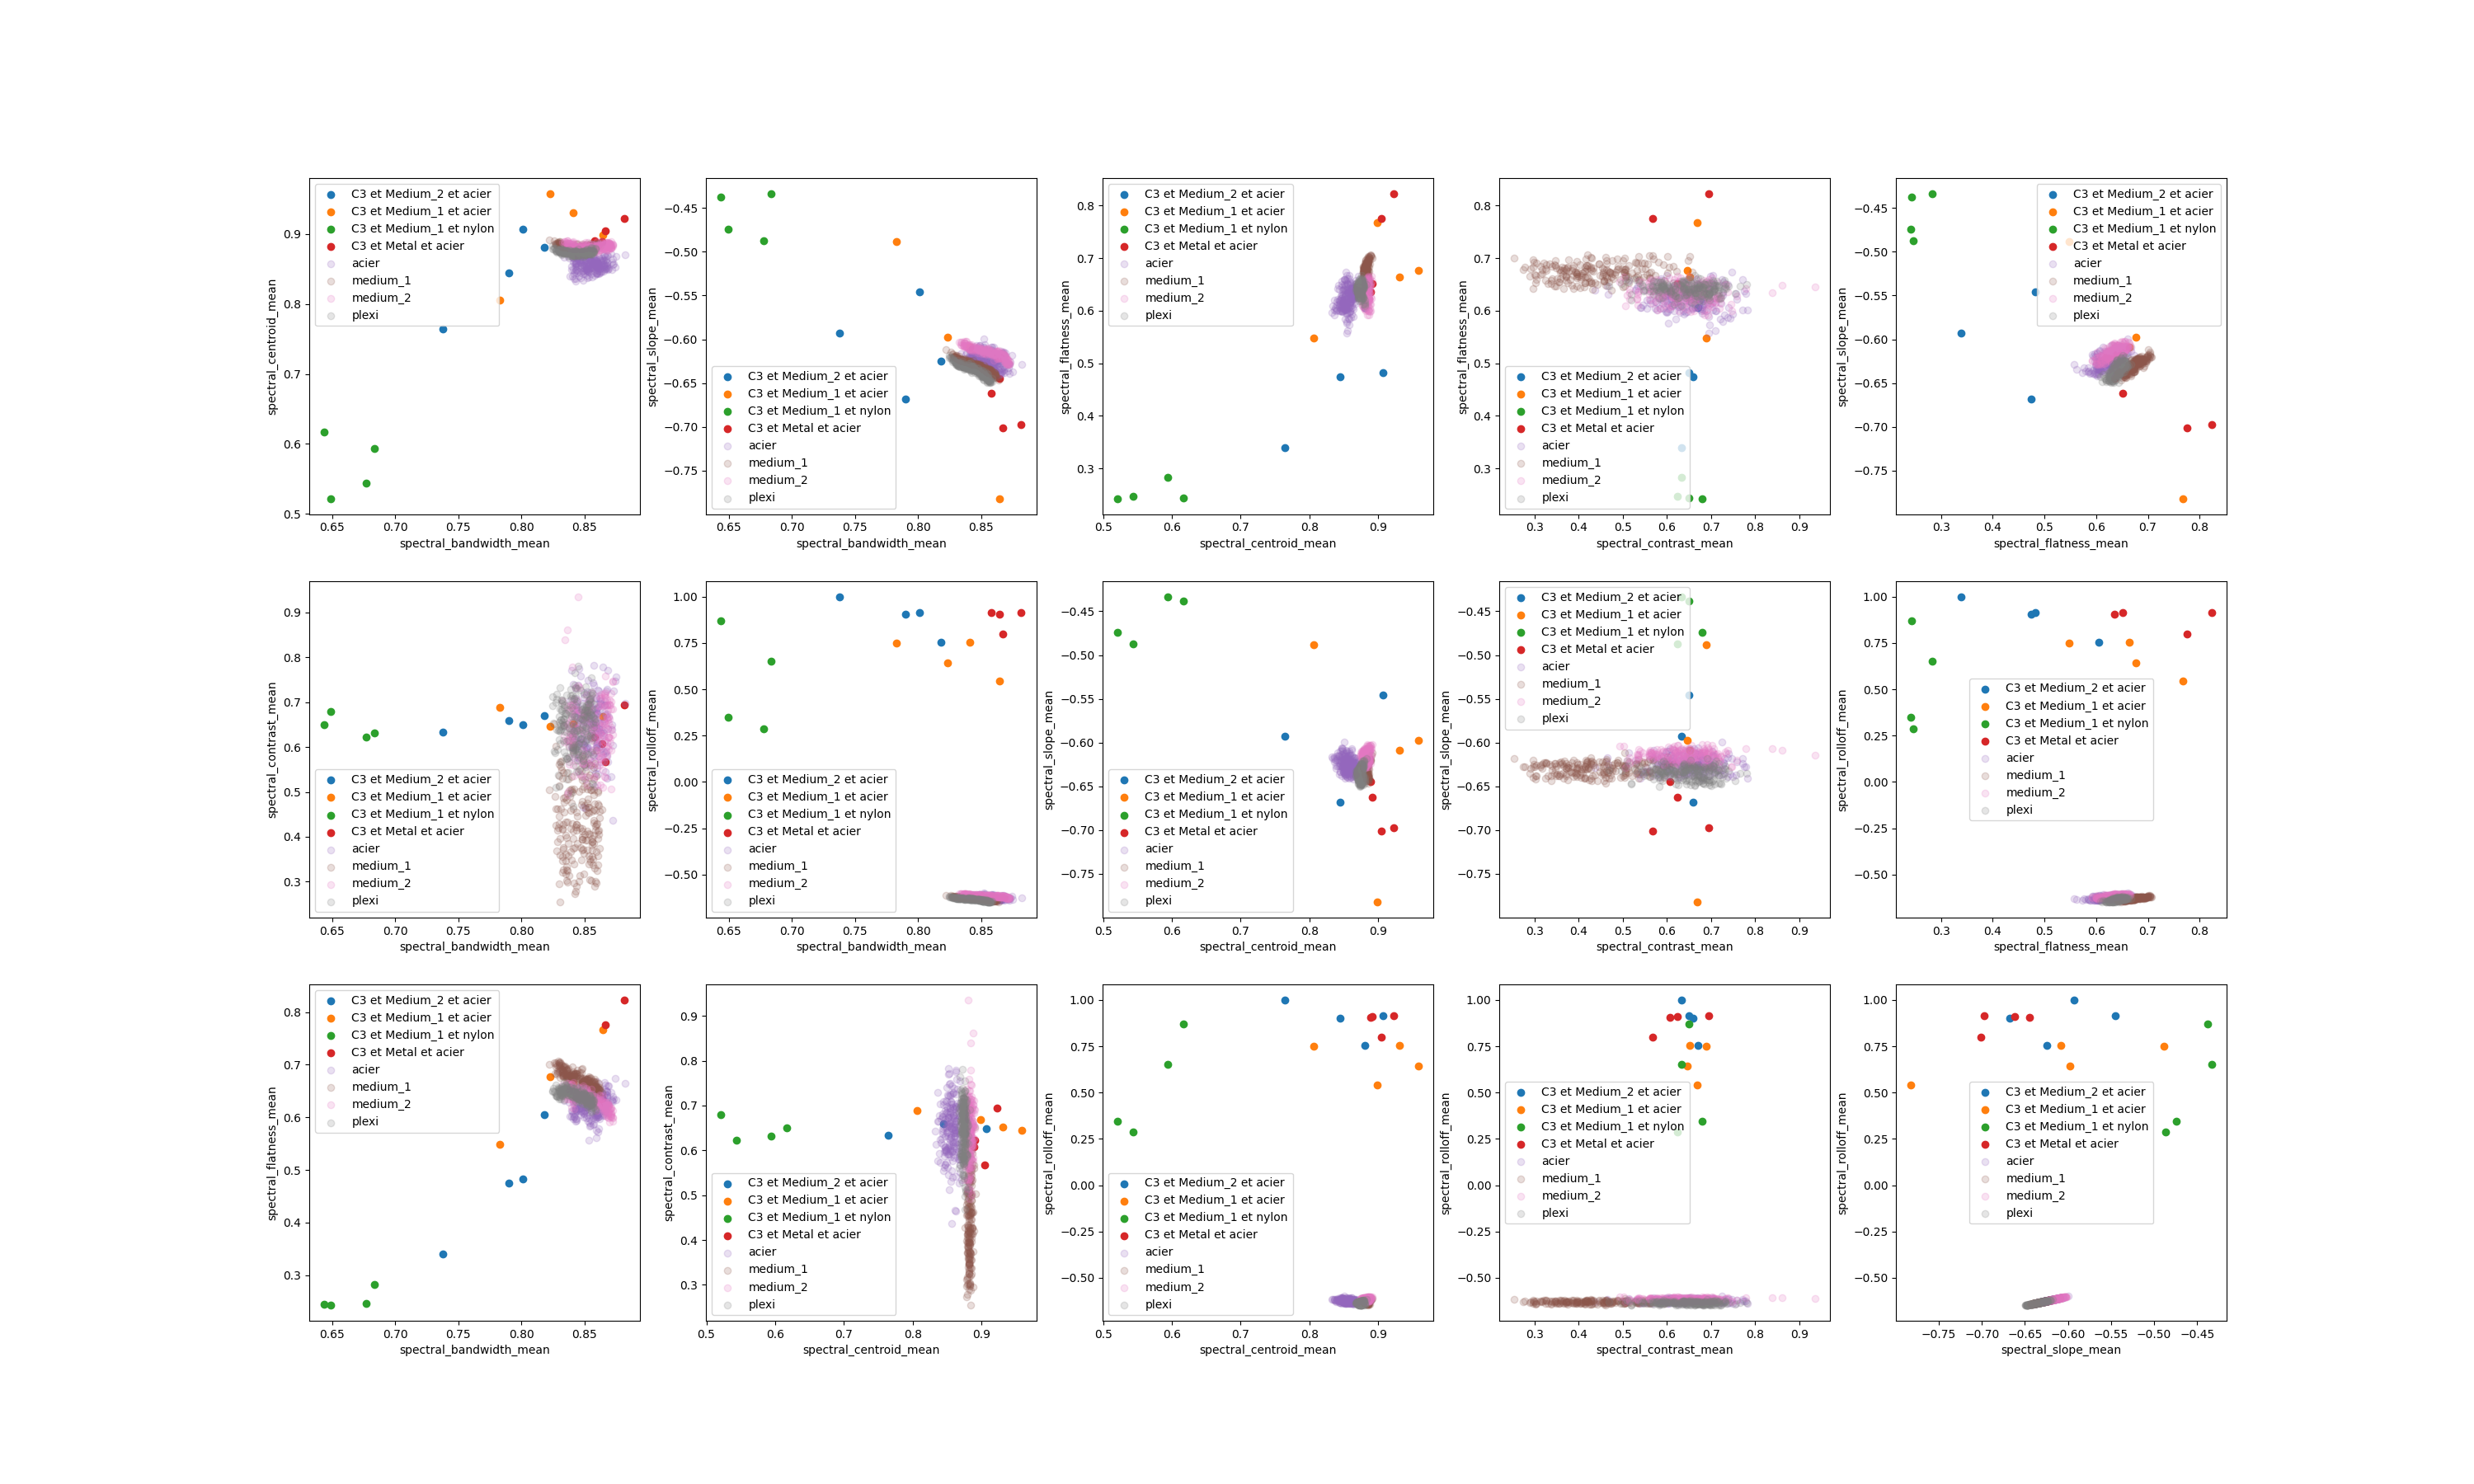

In [24]:
fig, ax = plt.subplots(3,5, figsize=(30,int(30*(3/5))))
i=0
j=0
for combinaison in liste_comb:
    k=0
    x_axis = []
    y_axis = []
    for cle in all_cle_exp:
        
        if 'C_3' in cle and 'Medium_2' in cle and 'Acier' in cle: # Il faut bien choisir quelles données d'expériences on veut visualiser
            x_axis.append(dict_class_mean_exp[cle][combinaison[0]])
            y_axis.append(dict_class_mean_exp[cle][combinaison[1]])
    ax[i,j].scatter(x_axis,y_axis,label='C3 et Medium_2 et acier')
    ax[i,j].set_xlabel(combinaison[0])
    ax[i,j].set_ylabel(combinaison[1])
    ax[i,j].legend()
    
    x_axis = []
    y_axis = []
    for cle in all_cle_exp:
        
        if 'C_3' in cle and 'Medium_1' in cle and 'Acier' in cle: # Il faut bien choisir quelles données d'expériences on veut visualiser
            x_axis.append(dict_class_mean_exp[cle][combinaison[0]])
            y_axis.append(dict_class_mean_exp[cle][combinaison[1]])
    ax[i,j].scatter(x_axis,y_axis,label='C3 et Medium_1 et acier')
    ax[i,j].set_xlabel(combinaison[0])
    ax[i,j].set_ylabel(combinaison[1])
    ax[i,j].legend()
    
    x_axis = []
    y_axis = []
    for cle in all_cle_exp:
        if 'C_3' in cle and 'Medium_1' in cle and 'Nylon' in cle: # Il faut bien choisir quelles données d'expériences on veut visualiser
            x_axis.append(dict_class_mean_exp[cle][combinaison[0]])
            y_axis.append(dict_class_mean_exp[cle][combinaison[1]])
    ax[i,j].scatter(x_axis,y_axis,label='C3 et Medium_1 et nylon')
    ax[i,j].set_xlabel(combinaison[0])
    ax[i,j].set_ylabel(combinaison[1])
    ax[i,j].legend()
    
    x_axis = []
    y_axis = []
    for cle in all_cle_exp:
        
        if 'C_3' in cle and 'Metal' in cle and 'Acier' in cle: # Il faut bien choisir quelles données d'expériences on veut visualiser
            x_axis.append(dict_class_mean_exp[cle][combinaison[0]])
            y_axis.append(dict_class_mean_exp[cle][combinaison[1]])
    ax[i,j].scatter(x_axis,y_axis,label='C3 et Metal et acier')
    ax[i,j].set_xlabel(combinaison[0])
    ax[i,j].set_ylabel(combinaison[1])
    ax[i,j].legend()
    
    
    for cle in dict_class.keys():
        x_axis = dict_class_mean[cle][combinaison[0]]
        y_axis = dict_class_mean[cle][combinaison[1]]
        ax[i,j].scatter(x_axis,y_axis,label=cle[28:-1], alpha=0.2)
        ax[i,j].set_xlabel(combinaison[0])
        ax[i,j].set_ylabel(combinaison[1])
        ax[i,j].legend()
    i+=1
    if i%3==0:
        j+=1
        i=0
        